In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets
import numpy as np
import data
import os.path
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
dvu.set_style()
import pandas as pd
import config
from os.path import join as oj
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

2022-08-13 22:26:38.358661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-13 22:26:38.358705: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [99]:
rs = data.load_fitted_results()
rs.to_pickle(oj(config.results_dir, 'fitted_results_aggregated.pkl'))

dsets ['emotion', 'financial_phrasebank', 'rotten_tomatoes', 'sst2', 'tweet_eval']


100%|██████████| 168/168 [00:05<00:00, 31.49it/s]


In [3]:
rs = pd.read_pickle(oj(config.results_dir, 'fitted_results_aggregated.pkl'))
rs.head()

,checkpoint,ngrams,subsample,all,norm,dataset,seed,layer,padding,dataset_key_text,num_features,acc_train,acc_val
0,aatmasidha/distilbert-base-uncased-finetuned-e...,1,-1,all,,emotion,1,last_hidden_state_mean,True,text,768,0.902500,0.8555
1,bert-base-uncased,1,-1,all,,emotion,1,pooler_output,True,text,768,0.536250,0.5340
2,bert-base-uncased,1,-1,all,,emotion,1,last_hidden_state_mean,True,text,768,0.709250,0.6730
3,countvectorizer,1,-1,all,,emotion,1,pooler_output,True,text,15165,0.993250,0.8880
4,distilbert-base-uncased,1,-1,all,,emotion,1,last_hidden_state_mean,True,text,768,0.687875,0.6590


In [ ]:
def dist(x):
    return 'distilbert' in x.lower()
dd = rs[rs.checkpoint.apply(dist)]
dd = dd[dd.dataset == 'sst2']
dd = dd[dd.subsample == -1]
dd

# best models table

In [21]:
def get_tab(checkpoint_names=['bert-finetuned', 'bert-base-uncased',
                              'countvectorizer', 'tfidfvectorizer']):
    def rename_checkpoint(checkpoint):
        cp = checkpoint.lower()
        if '/' in cp or 'finetune' in cp:
            if 'distilbert' in cp:
                return 'distilbert-finetuned'
            else:
                return 'bert-finetuned'
        else:
            return checkpoint

    rfull = rs[rs.subsample == -1]
    ans = defaultdict(list)
    ind_dsets = []
    for k, group in rfull.groupby('dataset'):
        ind_dsets.append(k)
        for kk in checkpoint_names:
            kkr = rename_checkpoint(kk)
            checkpoints = group.checkpoint.apply(rename_checkpoint).values
            if kkr in checkpoints:
                gg1 = group[(checkpoints == kkr)]
                
                # if there are multiple layers, default to pooler_output
                if len(np.unique(gg1.layer)) > 1: 
                    gg =  gg1[gg1.layer == 'pooler_output']
                else:
                    gg = gg1
                ans[kkr].append(gg['acc_val'].max())
                
                # if there are multiple layers, then add last_hidden_state as another key
                # print(kkr, np.unique(gg1.layer))
                if len(np.unique(gg1.layer)) > 1 and not np.all(gg1.layer == 'pooler_output'):
                    gg = group[(checkpoints == kkr) & (group.layer == 'last_hidden_state_mean')]
                    ans[kkr + '___last_hidden_state_mean'].append(gg['acc_val'].max())
            else:
                ans[kkr].append(np.nan)    

    keys = list(ans.keys())
    for k in keys:
        if len(ans[k]) < 5:
            print(k, 'not finished!')
            ans.pop(k)
    # print(ans)
    tab = pd.DataFrame.from_dict(ans).round(3)
    tab.index = map(data.DSETS_RENAME_DICT.get, ind_dsets, ind_dsets)
    tab.columns = map(data.COLUMNS_RENAME_DICT.get, tab.columns)
    # tab.style.highlight_max(color = 'lightgreen', axis=1)
    # tab.insert(len(tab.columns) - 1, 'BERT', tab.pop('BERT'))
    return tab
tab_main = get_tab(checkpoint_names=['bert-finetuned', 'countvectorizer', 'tfidfvectorizer'])
# tab_main.pop('Emb-grams (BERT finetuned final layer)')
tab_main.pop('Emb-grams (BERT finetuned)')
tab_main.round(2)

,Emb-grams (BERT finetuned final layer),Bag of ngrams,TF-IDF
Emotion,0.90,0.89,0.89
Financial phrasebank,0.93,0.85,0.85
Rotten tomatoes,0.82,0.75,0.76
SST2,0.87,0.82,0.84
Tweet (Hate),0.72,0.74,0.72


In [22]:
def bold_extreme_values(data):
    format_string="%.2f"
    max_=True
    if max_:
        extrema = data != data.max()
    else:
        extrema = data != data.min()
    bolded = data.apply(lambda x : "\\textbf{%s}" % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(extrema, bolded) 

tab2 = tab_main.apply(bold_extreme_values, axis=1)
print(tab2.to_latex(escape=False).replace('Emb-grams (BERT finetuned)', '\\textbf{Emb-grams (BERT finetuned)}'))

\begin{tabular}{llll}
\toprule
{} & Emb-grams (BERT finetuned final layer) &  Bag of ngrams & TF-IDF \\
\midrule
Emotion              &                          \textbf{0.90} &           0.89 &   0.89 \\
Financial phrasebank &                          \textbf{0.93} &           0.85 &   0.85 \\
Rotten tomatoes      &                          \textbf{0.82} &           0.75 &   0.76 \\
SST2                 &                          \textbf{0.87} &           0.82 &   0.84 \\
Tweet (Hate)         &                                   0.72 &  \textbf{0.74} &   0.72 \\
\bottomrule
\end{tabular}



# variations table

In [23]:
tab_variations = get_tab(checkpoint_names=['bert-finetuned', 'bert-base-uncased',
                          'distilbert-base-uncased', 'distilbert-finetuned',])
def fix_column(x):
    return x.replace('Emb-grams (', '')[:-1]
tab_variations.columns = [fix_column(x) for x in tab_variations.columns]
tab_variations

,BERT finetuned,BERT finetuned final layer,BERT,BERT final layer,DistilBERT,DistilBERT finetuned
Emotion,0.896,0.895,0.586,0.673,0.689,0.874
Financial phrasebank,0.932,0.929,0.824,0.836,0.850,0.813
Rotten tomatoes,0.812,0.816,0.780,0.784,0.787,0.799
SST2,0.877,0.872,0.813,0.825,0.817,0.868
Tweet (Hate),0.715,0.725,0.720,0.731,0.726,0.736


In [24]:
print(tab_variations.to_latex(escape=False))

\begin{tabular}{lrrrrrr}
\toprule
{} &  BERT finetuned &  BERT finetuned final layer &   BERT &  BERT final layer &  DistilBERT &  DistilBERT finetuned \\
\midrule
Emotion              &           0.896 &                       0.895 &  0.586 &             0.673 &       0.689 &                 0.874 \\
Financial phrasebank &           0.932 &                       0.929 &  0.824 &             0.836 &       0.850 &                 0.813 \\
Rotten tomatoes      &           0.812 &                       0.816 &  0.780 &             0.784 &       0.787 &                 0.799 \\
SST2                 &           0.877 &                       0.872 &  0.813 &             0.825 &       0.817 &                 0.868 \\
Tweet (Hate)         &           0.715 &                       0.725 &  0.720 &             0.731 &       0.726 &                 0.736 \\
\bottomrule
\end{tabular}



# all curves

In [ ]:
for dset in ['financial_phrasebank', 'rotten_tomatoes', 'sst2']: # rs.dataset.unique():
    r = rs[rs.dataset == dset]

    R = 1
    C = 3
    plt.figure(figsize=(12, 5))
    # plt.figure(figsize=(8, 12))
    for i, subsample in enumerate([100, 1000, -1]):
        plt.subplot(R, C, i + 1)
        plt.title('Num train=' + str(subsample))
        d = r[r.subsample == subsample]

        curve = sorted(d.groupby(['checkpoint', 'all', 'norm']),
                       key=lambda x: data.COLUMNS_RENAME_DICT.get(x[0][0], 'BERT finetuned'))
        curve.append(curve.pop(0)) # move BERT to bottom
        for key, group in curve:
            g = group.sort_values('ngrams')
            label = data.COLUMNS_RENAME_DICT.get(key[0], 'BERT finetuned')
            if label == 'BERT finetuned':
                plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=2, color='black')
            else:
                plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=1)
        plt.ylabel(f'Accuracy ({data.DSETS_RENAME_DICT.get(dset)})')
        plt.xlabel('N-gram size')
        plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
    plt.savefig(f'results/acc_by_ngrams_{dset}.pdf')
#     plt.show()    
    #     print(curve)

In [ ]:
r.checkpoint

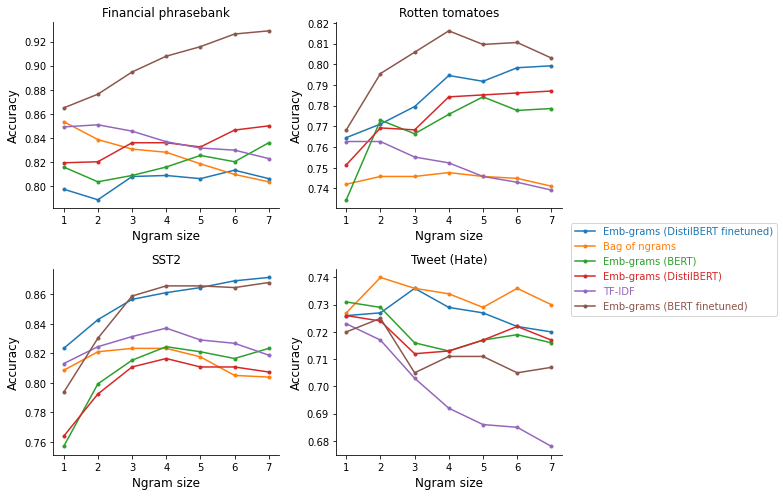

In [165]:
def is_bert(s):
    return 'bert' in s.lower()

plt.figure(figsize=(8, 7))
for i, dset in enumerate(['financial_phrasebank', 'rotten_tomatoes', 'sst2', 'tweet_eval']):
    r = rs[rs.dataset == dset]
    r = r[~((r.checkpoint.apply(is_bert) & (r.layer == 'pooler_output')))]

    plt.subplot(2, 2, i + 1)
    plt.title(f'{data.DSETS_RENAME_DICT.get(dset)}', fontsize='large')
    d = r[(r.subsample == -1)]

    curve = sorted(d.groupby(['checkpoint', 'all', 'norm']),
                   key=lambda x: data.COLUMNS_RENAME_DICT.get(x[0][0], 'BERT finetuned'))
    curve.append(curve.pop(0)) # move BERT to bottom
    for key, group in curve:
        g = group.sort_values('ngrams')
        if 'distilbert' in key[0].lower():
            label = data.COLUMNS_RENAME_DICT.get(key[0], 'Emb-grams (DistilBERT finetuned)')    
        else:
            label = data.COLUMNS_RENAME_DICT.get(key[0], 'Emb-grams (BERT finetuned)')
        if 'finteuned' in label:
            plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=2.5, color='black')
        else:
            plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=1.5)
    plt.ylabel(f'Accuracy', fontsize='large')
    plt.xlabel('Ngram size', fontsize='large')
#     plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                # mode="expand", borderaxespad=0, ncol=3)
plt.legend(bbox_to_anchor=(1.04, 1.0), loc="center left",
           borderaxespad=0, labelcolor='linecolor')
# plt.legend(, fontsize='large')
plt.savefig(f'results/acc_by_ngrams_full.pdf', bbox_inches='tight')
#     plt.show()    
    #     print(curve)

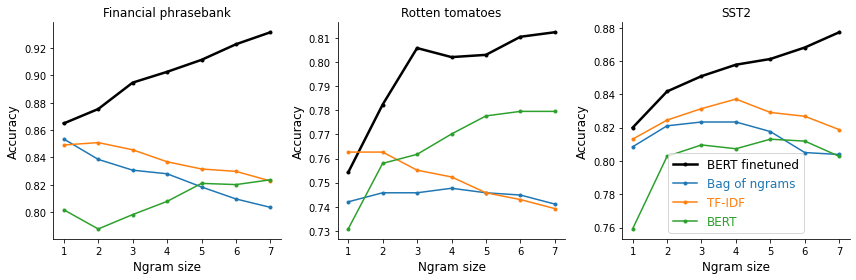

In [117]:
plt.figure(figsize=(12, 4))
for i, dset in enumerate(['financial_phrasebank', 'rotten_tomatoes', 'sst2']):
    r = rs[rs.dataset == dset]
    plt.subplot(1, 3, i + 1)
    plt.title(f'{data.DSETS_RENAME_DICT.get(dset)}', fontsize='large')
    d = r[r.subsample == subsample]

    curve = sorted(d.groupby(['checkpoint', 'all', 'norm']),
                   key=lambda x: data.COLUMNS_RENAME_DICT.get(x[0][0], 'BERT finetuned'))
    curve.append(curve.pop(0)) # move BERT to bottom
    for key, group in curve:
        g = group.sort_values('ngrams')
        label = data.COLUMNS_RENAME_DICT.get(key[0], 'BERT finetuned')
        if label == 'BERT finetuned':
            plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=2.5, color='black')
        else:
            plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=1.5)
    plt.ylabel(f'Accuracy', fontsize='large')
    plt.xlabel('Ngram size', fontsize='large')
#     plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
plt.legend(labelcolor='linecolor', fontsize='large')
# plt.savefig(f'results/acc_by_ngrams_full.pdf')
#     plt.show()    
    #     print(curve)